# Hugging Face Library 'Transformer'およびT5Tokenizerのダウンロード

参考(https://qiita.com/takubb/items/fd972f0ac3dba909c293)これを基に改造し、最新のGoogle Colaboratoryで動作するようにした

In [1]:
!export CUDA_LAUNCH_BLOCKING=1
# !pip install torch
!pip install torchvision
!pip install transformers
#!apt install swig
# Sentencepieceのインストール
!pip install sentencepiece
!pip install mecab-python3
from transformers import T5Tokenizer
tokenizer = T5Tokenizer.from_pretrained("rinna/japanese-roberta-base")
tokenizer.do_lower_case = True  # due to some bug of tokenizer config loading

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" 
import gzip
import shutil
import sqlite3
import random
from math import ceil
import re
import csv
import glob
import torchvision
import statistics
import numpy as np
import lightgbm
import pickle
import statistics
import MeCab
import re
import copy

import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

# PyTorchとGPU設定

In [3]:
#!pip install torch
import torch
# GPUが使えれば利用する設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Data Augmentation kansuu

In [4]:
# synreplace - replace kasho kosuu
# randinsert - tasu kotoba no kazu
# randdelete - delete kakuritsu
# randswap - swap kaisuu

class synreplace(object):
    def __init__(self, num):
        self.num = num
        self.model = RobertaForMaskedLM.from_pretrained("rinna/japanese-roberta-base")
    def __call__(self, textlist):
        # textlist: honbun no list
        textlen = torch.where(textlist == 3)[0][0]
        for n in range(self.num):
            # chikan shiro
            masked_idx = random.randint(2, textlen-1)
            textlist[masked_idx] = 6
            # convert to tensor
            token_tensor = torch.tensor(textlist)
            # get the top 10 predictions of the masked token
            self.model = self.model.eval()
            with torch.no_grad():
                outputs = self.model(torch.unsqueeze(token_tensor, 0))
                predictions = outputs[0][0, masked_idx].topk(1)
            for i, index_t in enumerate(predictions.indices):
                index = index_t.item()
            textlist[masked_idx] = index
        return textlist

class randinsert(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
        for n in range(self.num):
            insword = textlist[random.randint(1,len(textlist)-1)]
            i = random.randint(1,len(textlist)-1)
#            print('len: ', len(textlist))
#            print(i)
            while textlist[i] == 3:
                i = random.randint(1,len(textlist)-1)
#                print(i)
            textlist = torch.cat([textlist[0:i], torch.tensor([insword]), textlist[i:-1]])
        return textlist

class randdelete(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
#        print(textlist.shape)
        for i in range(3,len(textlist)-1):
            if textlist[i] == 3:
                continue
            r = random.uniform(0, 1)
            if r < self.num:
#                textlist.pop(i)
                textlist = torch.cat([textlist[0:i], textlist[i+1:], torch.tensor([3])])
#                print(textlist)
        return textlist

class randswap(object):
    def __init__(self, num):
        self.num = num
    def __call__(self, textlist):
        counter = 0
        #rs_sents = np.zeros(len(textlist), dtype=object)
        for i in range(len(textlist)):
            while self.num > counter:
                box = 0
                random_idx_1 = random.randint(1, len(textlist)-1)
                while textlist[random_idx_1] == 3:
                    random_idx_1 = random.randint(0, len(textlist)-1)
                random_idx_2 = random.randint(1, len(textlist)-1)
                while random_idx_1 == random_idx_2 or textlist[random_idx_2] == 3:
                    random_idx_2 = random.randint(0, len(textlist)-1)
                    # print(random_idx_1, random_idx_2)
                box = textlist[random_idx_1]
                textlist[random_idx_1] = textlist[random_idx_2]
                textlist[random_idx_2] = box
                counter += 1
        return textlist

# Custom Tensor Dataset
https://stackoverflow.com/questions/55588201/pytorch-transforms-on-tensordataset

# データセットの準備

ライブドアニュースコーパスをダウンロード

    ダウンロードしたファイルは圧縮（tar.gz形式）ファイル
    様々なジャンル（IT,スポーツ,家電,映画など）のWEBメディアごとにフォルダに記事がテキストファイルで保存されている
    
以下、ファイルを読み込んで、必要な部分を抽出

In [5]:
#urllib.request.urlretrieve("https://www.rondhuit.com/download/ldcc-20140209.tar.gz", "ldcc-20140209.tar.gz")
# ダウンロードした圧縮ファイルのパスを設定
#tgz_fname = "ldcc-20140209.tar.gz" 
# 2つをニュースメディアのジャンルを選定
mydata = '/export/livedoor' 
#処理をした結果を保存するファイル名 
tsv_fname = "all_text.tsv" 

def remove_brackets(inp):
    output = re.sub(u'[〃-〿]', '',(re.sub('＝|=|×|\(|\)|“|”|（|）|／|\[|\]| |　|…|・|\n|\t|/|＜|＞|@|＠', '', re.sub(u'[ℊ-⿻]', '', inp)))) #210A ~ 2FFF
    return output

"""
def read_url(f):
    url = next(f)
    return url[:-1]

def read_date(f):
    date = next(f)
    date = remove_brackets(date.encode().decode('utf-8'))
    return date[:-1]
"""

def read_title(f):
    next(f)
    next(f)
    title = next(f)
    title = remove_brackets(title.encode().decode('utf-8'))
    return title[:-1]

def read_para(f):
    p = ''
    while True:
        try:
            para = next(f)
            para = remove_brackets(para.encode().decode('utf-8'))
            p += para
        except StopIteration:
            break
    return p [:-1]

In [6]:
#directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/it-life-hack']
#target_genre = ["dokujo-tsushin", "it-life-hack"] 
directory = ['/export/livedoor/dokujo-tsushin', '/export/livedoor/peachy']
target_genre = ["dokujo-tsushin", "peachy"] 
zero_fnames = []
one_fnames = []

if os.path.exists(tsv_fname) == True:
    with open(tsv_fname, "r+") as f:
        f.truncate(0)

for i in range(2):
    for filename in os.listdir(directory[i]):
        if "LICENSE.txt" in filename:
            continue
        f = os.path.join(directory[i], filename)
        #if os.path.isfile(f):
        #    print(f)
        if target_genre[0] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[0], '0', title, para]
                    writer.writerow(row)
            continue
        if target_genre[1] in f and f.endswith(".txt"):
            with open(tsv_fname, "a") as wf:
                writer = csv.writer(wf, delimiter='\t')
                with open(f) as zf:
                    title = read_title(zf)
                    para = read_para(zf)
                    row = [target_genre[1], '1', title, para]
                    writer.writerow(row)
            continue

pandasでデータを読み込み

In [7]:
import pandas as pd
# データの読み込み
df = pd.read_csv("all_text.tsv", 
                 delimiter='\t', header=None, names=['media_name', 'label','title','sentence'])


#df_ = pd.read_csv("summary_set_dokujo_it.tsv", 
#                 delimiter='\t', header=None, names=['summaries'])

df_ = pd.read_csv("summary_set_dokujo_peachy.tsv", 
                 delimiter='\t', header=None, names=['summaries'])

# データの確認
print(f'データサイズ： {df.shape}')
df.sample(10)

データサイズ： (1712, 4)


,media_name,label,title,sentence
1279,peachy,1,まだ間に合う、癒しと大人のクリスマ,いよいよ、本格的なクリスマスシーズンに突入しました。イルミネーションスポットに赴き、美しい夜...
1615,peachy,1,終了しました食べてキレイに！美フードバトル美禅食を10名様にプレゼン,写真一覧8件仕事に恋に、てんてこまいな女子の毎日。キレイへの近道は食生活を改善することとはわ...
1626,peachy,1,遊びで終わる女の特徴結婚前に二人の相性を再チェックなど恋愛週間ランキン,Peachyでも大人気の恋愛をテーマにした記事の週間ランキングです！2012年8月16日8月...
804,dokujo-tsushin,0,オトナ女子のリアルな悩み2年前に勤めていた会社の人を今頃になって好き,タイミングは恋するうえで重要な要素である。もし、好きな人が出来たとしても、タイミングが悪けれ...
1643,peachy,1,超簡単な二の腕ほっそり体操ティッシュ箱で骨盤を鍛えるお気に入り登録記事週間ランキン,Peachyアプリを利用している皆さま、アプリのお気に入り機能は使っていますか？お気に入りと...
319,dokujo-tsushin,0,大震災をきっかけに考える。在宅勤務はアリかナシか,東日本大震災の影響で、電力不足が懸念される今年の夏。サマータイムの導入やお盆休みの分散化など...
899,peachy,1,伝説の4人に日本中が熱狂！SATC2ジャパンプレミ,全世界興収4億ドルを記録した映画の続編セックスアンドザシティ2がいよいよ6月4日より全国ロー...
23,dokujo-tsushin,0,節電しながらムーディーな照明で夜を楽しもう,東日本大震災直後は節電で夜の街が暗くなり、電気のありがたみを実感したものだった。あれからもう...
1157,peachy,1,JYJユチョン主演のスリリングな恋愛ドラマミスリプリーレンタル開始決,愛と嘘の心理戦が観るものを惹きつけるドラマミスリプリー。韓国では初回放送から視聴率1位を獲得...
1112,peachy,1,向井理さんの今の時間帯だと言えないヒミ,昨年一大ブームを巻き起こしたドラマゲゲゲの女房で、人気を不動のものにした向井理さん。9日、ク...


//文章データをsentences、ラベルデータを labelsに保存、以降この2変数だけを利用

In [8]:
mn = df.media_name.values
labels = df.label.values
titles = df.title.values
sentences = df.sentence.values
summaries = df_.summaries.values

In [9]:
print(type(labels))

<class 'numpy.ndarray'>


In [10]:
tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
  # MeCabで分かち書きを行う
    sentence = tagger.parse(sentence)
  # 半角全角英数字などは削除する
#    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
  # 記号なども削除する
#    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
  # スペース区切で形態素の配列に変換する
    wakati = sentence.split(" ")
  # 空要素を削除する
    wakati = list(filter(("").__ne__, wakati))
    return wakati

In [11]:
hoge=make_wakati(sentences[2])
hoge[0]

'結婚'

In [12]:
wakati_sentences = []

for i in range(len(sentences)):
    wakati_sentences.append(make_wakati(sentences[i]))

In [13]:
hoge = []
hoge.append(wakati_sentences[0][0])
hoge += wakati_sentences[0][1]
hoge += wakati_sentences[0][2]
hoge

['両親', 'や', '親', '族']

In [14]:
for i in enumerate(wakati_sentences):
    continue
print(i[0])

1711


In [15]:
wcount = 128

h_sentences = []
t_sentences = []

# wcount moji me kara kesu

for i in enumerate(wakati_sentences):
    #h_sent = []
    h_len = 0
    hn = 0
    #h_sent.append(wakati_sentences[i[0]][0])
    h_len += len(wakati_sentences[i[0]][0])
    while h_len < wcount:
        try:
            hn += 1
            if wakati_sentences[i[0]][hn]:
                #print(hn, wakati_sentences[i[0]][hn])
                #h_sent.append(wakati_sentences[i[0]][hn])
                h_len += len(wakati_sentences[i[0]][hn])
        except IndexError:
            break
    h_sentences.append(sentences[i[0]][:hn])
    
    #t_sent = []
    t_len = 0
    tn = 2
    #t_sent.append(wakati_sentences[i[0]][-2])
    t_len += len(wakati_sentences[i[0]][-2])
    while t_len < wcount:
        try:
            tn += 1
            if wakati_sentences[i[0]][tn]:
                #print(tn, wakati_sentences[i[0]][tn])
                #t_sent.append(wakati_sentences[i[0]][tn])
                t_len += len(wakati_sentences[i[0]][tn])
        except IndexError:
            break
    t_sentences.append(sentences[i[0]][-tn:])

In [16]:
h_sentences[0]

'両親や親族が高齢なってくると、自分の人生を見つめ直さないといけないことがある。自分が独女の場合はなお更である。今回の相談者ミミさん女性38歳は母親が介護が必要になった'

In [17]:
hsentences = np.array(h_sentences)
tsentences = np.array(t_sentences)

In [18]:
ssentences = np.array(df_.summaries.values)

In [19]:
np.array(ssentences).shape

(1712,)

In [20]:
emp = []
asentences = np.append(emp, copy.deepcopy(sentences))
ksentences = np.append(emp, copy.deepcopy(sentences))
kksentences = np.append(emp, copy.deepcopy(sentences))

# wcount moji me kara kesu

for i in enumerate(sentences):
    if len(i[1])>wcount:
        asentences[i[0]] = sentences[i[0]][:wcount]

# ushiro kara wcount moji toru

for i in enumerate(sentences):
    if len(i[1])>wcount:
        ksentences[i[0]] = sentences[i[0]][-wcount:]

# ushiro kara wcount moji toru ichiban ketsu wa toranai

for i in enumerate(sentences):
    if len(i[1])>wcount:
        am = wcount+10
        a = sentences[i[0]][-am:]
        kksentences[i[0]] = a[:wcount]

In [21]:
ksentences[2]

'と。絶えず自分が彼にとって何ができるかを考え、それを実行することに尽きると思う。しかしどんなに努力をしても、彼の心が離れてしまうこともある。そういう時は去る者は追わず。彼をつなぎ止めようとした努力は、次の恋に必ず役に立つと信じよう。オフィスエムツー佐枝せつ'

# BERT Tokenizerを用いて単語分割・IDへ変換
## Tokenizerの準備
単語分割とIDへ変換

# テスト実行

In [22]:
# 最大単語数の確認
max_len = []
# 1文づつ処理
for sent in hsentences:
    # Tokenizeで分割
    h_token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(h_token_words))
for sent in tsentences:
    # Tokenizeで分割
    t_token_words = tokenizer.tokenize(sent)
    # 文章数を取得してリストへ格納
    max_len.append(len(t_token_words))
# 最大の値を確認
print('最大単語数: ', max(max_len))
print('上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数')

最大単語数:  63
上記の最大単語数にSpecial token（[CLS], [SEP]）の+2をした値が最大単語数


In [23]:
h_input_ids = []
t_input_ids = []
a_input_ids = []
k_input_ids = []
kk_input_ids = []
s_input_ids = []
h_attention_masks = []
t_attention_masks = []
a_attention_masks = []
k_attention_masks = []
kk_attention_masks = []
s_attention_masks = []

# 1文づつ処理
for sent in hsentences:
    hencoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # print(hencoded_dict)

    h_input_ids.append(hencoded_dict['input_ids'])
    h_attention_masks.append(hencoded_dict['attention_mask'])
    
for sent in tsentences:
    tencoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # https://qiita.com/YuiKasuga/items/343309257da1798c1b63

    # 単語IDを取得    
    t_input_ids.append(tencoded_dict['input_ids'])

    # Attention　maskの取得
    t_attention_masks.append(tencoded_dict['attention_mask'])
    
for sent in asentences:
    aencoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # print(hencoded_dict)

    a_input_ids.append(aencoded_dict['input_ids'])
    a_attention_masks.append(aencoded_dict['attention_mask'])
    
for sent in ksentences:
    kencoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # print(hencoded_dict)

    k_input_ids.append(kencoded_dict['input_ids'])
    k_attention_masks.append(kencoded_dict['attention_mask'])
    
for sent in kksentences:
    kkencoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # print(hencoded_dict)

    kk_input_ids.append(kkencoded_dict['input_ids'])
    kk_attention_masks.append(kkencoded_dict['attention_mask'])
    
for summa in ssentences:
    sencoded_dict = tokenizer.encode_plus(
                        summa,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = 50,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # 単語IDを取得    
    s_input_ids.append(sencoded_dict['input_ids'])
    # Attention　maskの取得
    s_attention_masks.append(sencoded_dict['attention_mask'])

# リストに入ったtensorを縦方向（dim=0）へ結合
h_input_ids = torch.cat(h_input_ids, dim=0)
t_input_ids = torch.cat(t_input_ids, dim=0)
a_input_ids = torch.cat(a_input_ids, dim=0)
k_input_ids = torch.cat(k_input_ids, dim=0)
kk_input_ids = torch.cat(kk_input_ids, dim=0)
s_input_ids = torch.cat(s_input_ids, dim=0)
h_attention_masks = torch.cat(h_attention_masks, dim=0)
t_attention_masks = torch.cat(t_attention_masks, dim=0)
a_attention_masks = torch.cat(a_attention_masks, dim=0)
k_attention_masks = torch.cat(k_attention_masks, dim=0)
kk_attention_masks = torch.cat(kk_attention_masks, dim=0)
s_attention_masks = torch.cat(s_attention_masks, dim=0)

# tenosor型に変換
labels = torch.tensor(labels)

# 確認
print('Original: ', hsentences[0])
print('Original: ', tsentences[0])
print('Token IDs:', h_input_ids[0])
print(type(labels), labels)
print(torch.Tensor.size(h_input_ids))
print(torch.Tensor.size(h_attention_masks))
print(torch.Tensor.size(labels))
print(hsentences.size)

Original:  両親や親族が高齢なってくると、自分の人生を見つめ直さないといけないことがある。自分が独女の場合はなお更である。今回の相談者ミミさん女性38歳は母親が介護が必要になった
Original:  話占いメール占いでは霊感鑑定はもちろん、タロットから運勢の流れを読み解き、また、夢分析から近未来を予測します。関連サイトnifty電話占いメール占い翔生先生プロフィー
Token IDs: tensor([    9,  3652,    26, 13508,    12, 19860,    57,  9123,    20,     7,
         1393,  4221,  1429, 15133,   442,  4569,    20, 19133,  1272,     8,
         5144,  2596,   612,  2855,  3244, 13426,    27,     8, 16058,  5448,
          147,   318,   318,   774,   577,  1300,   559,    11,  4180,    12,
        12079,  3413,   344,     2,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     3,     3,     3,     3,     3,     3,     3,     3,     3,
            3,     

In [24]:
h_input_ids

tensor([[    9,  3652,    26,  ...,     3,     3,     3],
        [    9,  3911,    10,  ...,     3,     3,     3],
        [    9,  1743, 26243,  ...,     3,     3,     3],
        ...,
        [    9,  1583,  3887,  ...,     3,     3,     3],
        [  692, 10359,   693,  ...,     3,     3,     3],
        [    9,  1583,  3887,  ...,     3,     3,     3]])

In [25]:
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torchvision import transforms, datasets
from transformers import RobertaForMaskedLM

# データセットクラスの作成
# dataset = TensorDataset(h_input_ids, h_attention_masks, labels)
hdataset = TensorDataset(h_input_ids, h_attention_masks, labels)
tdataset = TensorDataset(t_input_ids, t_attention_masks, labels)
adataset = TensorDataset(a_input_ids, a_attention_masks, labels)
kdataset = TensorDataset(k_input_ids, k_attention_masks, labels)
kkdataset = TensorDataset(kk_input_ids, kk_attention_masks, labels)
sdataset = TensorDataset(s_input_ids, s_attention_masks, labels)
# dataset = CustomTensorDataset(tensors = (input_ids, labels), transform = None)


In [26]:
# 80%地点のIDを取得
num_dataset = len(hdataset)
#train_size = int(0.1 * num_dataset)
#val_size = num_dataset - train_size

train_size = 50
val_size = len(hdataset) - train_size

# データセhttp://localhost:8888/notebooks/bert-zuco/augmentation/BERTclassification-mydata-local-augmentation-aug.ipynb#ットを分割
h_train_dataset, h_val_dataset = random_split(hdataset, [train_size, val_size])
t_train_dataset, t_val_dataset = random_split(tdataset, [train_size, val_size])
a_train_dataset, a_val_dataset = random_split(adataset, [train_size, val_size])
k_train_dataset, k_val_dataset = random_split(kdataset, [train_size, val_size])
kk_train_dataset, kk_val_dataset = random_split(kkdataset, [train_size, val_size])
s_train_dataset, s_val_dataset = random_split(sdataset, [train_size, val_size])

print('訓練データ数:{}'.format(train_size))
print('検証データ数:{}'.format(val_size))

# データローダーの作成
#batch_size = train_size
batch_size = 50

data_transform = transforms.Compose([
    synreplace(1),
    randinsert(3),
    randdelete(0.15), 
    randswap(2)
])


class MySubset(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform

    def __getitem__(self, idx):
        xa, mask, label = self.dataset[self.indices[idx]]
        if self.transform:
            xa = self.transform(xa)
        return xa, mask, label

    def __len__(self):
        return len(self.indices)
    
indices = np.random.choice(num_dataset, num_dataset, replace=False)

h_train_dataset = MySubset(hdataset, indices[:train_size], data_transform)
h_val_dataset = MySubset(hdataset, indices[train_size:])
t_train_dataset = MySubset(tdataset, indices[:train_size], data_transform)
t_val_dataset = MySubset(tdataset, indices[train_size:])
a_train_dataset = MySubset(adataset, indices[:train_size], data_transform)
a_val_dataset = MySubset(adataset, indices[train_size:])
k_train_dataset = MySubset(kdataset, indices[:train_size], data_transform)
k_val_dataset = MySubset(kdataset, indices[train_size:])
kk_train_dataset = MySubset(kkdataset, indices[:train_size], data_transform)
kk_val_dataset = MySubset(kkdataset, indices[train_size:])
s_train_dataset = MySubset(sdataset, indices[:train_size], data_transform)
s_val_dataset = MySubset(sdataset, indices[train_size:])


# 訓練データローダー
h_train_dataloader = DataLoader(
            h_train_dataset,  
            sampler = RandomSampler(h_train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
            )
t_train_dataloader = DataLoader(
            t_train_dataset,
            sampler = RandomSampler(t_train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
            )
a_train_dataloader = DataLoader(
            a_train_dataset,
            sampler = RandomSampler(a_train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
            )
k_train_dataloader = DataLoader(
            k_train_dataset,
            sampler = RandomSampler(k_train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
            )
kk_train_dataloader = DataLoader(
            kk_train_dataset,
            sampler = RandomSampler(kk_train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
            )
s_train_dataloader = DataLoader(
            s_train_dataset,
            sampler = RandomSampler(s_train_dataset), # ランダムにデータを取得してバッチ化
            batch_size = batch_size
            )


# 検証データローダー
h_validation_dataloader = DataLoader(
            h_val_dataset, 
            sampler = SequentialSampler(h_val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )
t_validation_dataloader = DataLoader(
            t_val_dataset, 
            sampler = SequentialSampler(t_val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )
a_validation_dataloader = DataLoader(
            a_val_dataset, 
            sampler = SequentialSampler(a_val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )
k_validation_dataloader = DataLoader(
            k_val_dataset, 
            sampler = SequentialSampler(k_val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )
kk_validation_dataloader = DataLoader(
            kk_val_dataset, 
            sampler = SequentialSampler(kk_val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )
s_validation_dataloader = DataLoader(
            s_val_dataset, 
            sampler = SequentialSampler(s_val_dataset), # 順番にデータを取得してバッチ化
            batch_size = batch_size
        )

訓練データ数:50
検証データ数:1662


In [27]:
len(h_train_dataset)

50

In [28]:
from transformers import BertForSequenceClassification,AdamW,BertConfig

# BertForSequenceClassification 学習済みモデルのロード
model = BertForSequenceClassification.from_pretrained(
    "cl-tohoku/bert-base-japanese-whole-word-masking", # 日本語Pre trainedモデルの指定
    num_labels = 2, # ラベル数（今回はBinaryなので2、数値を増やせばマルチラベルも対応可）
    output_attentions = False, # アテンションベクトルを出力するか
    output_hidden_states = False, # 隠れ層を出力するか
)

# モデルをGPUへ転送
model.cuda()


2022-12-20 03:37:53.673152: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-20 03:37:53.797169: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-12-20 03:37:54.223133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-20 03:37:54.223178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [29]:
# 最適化手法の設定
optimizer = AdamW(model.parameters(), lr=2e-5)

# 訓練パートの定義
def h_train(model):
    model.train() # 訓練モードで実行
    h_train_loss = 0
    for batch in h_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        h_train_loss += loss.item()
    return h_train_loss


# テストパートの定義
def h_validation(model):
    model.eval()# 訓練モードをオフ
    h_val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in h_validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            h_val_loss += loss.item()
    return h_val_loss


In [30]:
def t_train(model):
    model.train() # 訓練モードで実行
    t_train_loss = 0
    for batch in t_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        t_train_loss += loss.item()
    return t_train_loss

def t_validation(model):
    model.eval()# 訓練モードをオフ
    t_val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in t_validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            t_val_loss += loss.item()
    return t_val_loss

In [31]:
def a_train(model):
    model.train() # 訓練モードで実行
    a_train_loss = 0
    for batch in a_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        a_train_loss += loss.item()
    return a_train_loss

def a_validation(model):
    model.eval()# 訓練モードをオフ
    a_val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in a_validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            a_val_loss += loss.item()
    return a_val_loss

In [32]:
def k_train(model):
    model.train() # 訓練モードで実行
    k_train_loss = 0
    for batch in k_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        k_train_loss += loss.item()
    return k_train_loss

def k_validation(model):
    model.eval()# 訓練モードをオフ
    k_val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in k_validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            k_val_loss += loss.item()
    return k_val_loss

In [33]:
def kk_train(model):
    model.train() # 訓練モードで実行
    kk_train_loss = 0
    for batch in kk_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        kk_train_loss += loss.item()
    return kk_train_loss

def kk_validation(model):
    model.eval()# 訓練モードをオフ
    kk_val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in kk_validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            kk_val_loss += loss.item()
    return kk_val_loss

In [34]:
def s_train(model):
    model.train() # 訓練モードで実行
    s_train_loss = 0
    for batch in s_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        s_train_loss += loss.item()
    return s_train_loss

def s_validation(model):
    model.eval()# 訓練モードをオフ
    s_val_loss = 0
    with torch.no_grad(): # 勾配を計算しない
        for batch in s_validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)
            with torch.no_grad():        
                (loss, logits) = model(b_input_ids, 
                                    token_type_ids=None, 
                                    attention_mask=b_input_mask,
                                    labels=b_labels)
            s_val_loss += loss.item()
    return s_val_loss

In [35]:
# 学習の実行
max_epoch = 50
t_train_loss_ = []
t_test_loss_ = []
h_train_loss_ = []
h_test_loss_ = []
a_train_loss_ = []
a_test_loss_ = []
k_train_loss_ = []
k_test_loss_ = []
kk_train_loss_ = []
kk_test_loss_ = []
s_train_loss_ = []
s_test_loss_ = []


h_train_loss = 0
t_train_loss = 0
a_train_loss = 0
k_train_loss = 0
kk_train_loss = 0
s_train_loss = 0

for epoch in range(max_epoch):
    h_train_ = h_train(model)
    h_test_ = h_train(model)
    h_train_loss_.append(h_train_)
    h_test_loss_.append(h_test_)


In [36]:
# b_input_mask.size(), b_input_ids.size(), labels.size()
# outputs = self.model(torch.unsqueeze(token_tensor, 0))

In [37]:
hoge = h_train_dataloader.__iter__()
hoge.next()

[tensor([[    9,     3,  7144,  ...,     3,     3,     3],
         [    9,  1055,     9,  ...,     3,     3,     3],
         [ 2732,     9,     9,  ...,     3,     3,     3],
         ...,
         [ 1042,     9,     9,  ...,     3,     3,     3],
         [    9, 22213,    27,  ...,     3,     3,     3],
         [ 9099,    22,  2090,  ...,     3,     3,     3]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0,
         1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0,
         1, 0])]

In [38]:
model.train() # 訓練モードで実行
h_test_accuracy = []
hoge = 0
hogehoge = 0

for epoch in range(max_epoch):
    h_train_ = h_train(model)
    h_test_ = h_train(model)
    h_train_loss_.append(h_train_)
    h_test_loss_.append(h_test_)

for batch in h_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
#    b_input_ids = batch[0].to(device)
#    b_input_mask = batch[1].to(device)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = torch.t(batch[2]).to(device)
    optimizer.zero_grad()
    outputs = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    h_loss = outputs.loss
    h_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    h_train_loss += h_loss.item()

model.eval()# 訓練モードをオフ

# print(h_preds)

for batch in h_validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        h_preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        h_test_accuracy.append((torch.argmax(h_preds[0], 1) == b_labels).sum().item() / len(b_labels))

In [39]:
for epoch in range(max_epoch):
    t_train_ = t_train(model)
    t_test_ = t_train(model)
    t_train_loss_.append(t_train_)
    t_test_loss_.append(t_test_)

model.train() # 訓練モードで実行
t_test_accuracy = []

for batch in t_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
#    b_input_ids = batch[0].to(device)
#    b_input_mask = batch[1].to(device)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = torch.t(batch[2]).to(device)
    optimizer.zero_grad()
    outputs = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    t_loss = outputs.loss
    t_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    t_train_loss += t_loss.item()
    
model.eval()# 訓練モードをオフ

for batch in t_validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        t_preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        t_test_accuracy.append((torch.argmax(t_preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)

In [40]:
for epoch in range(max_epoch):
    a_train_ = a_train(model)
    a_test_ = a_train(model)
    a_train_loss_.append(a_train_)
    a_test_loss_.append(a_test_)

model.train() # 訓練モードで実行
a_test_accuracy = []

for batch in a_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
#    b_input_ids = batch[0].to(device)
#    b_input_mask = batch[1].to(device)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = torch.t(batch[2]).to(device)
    optimizer.zero_grad()
    outputs = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    a_loss = outputs.loss
    a_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    a_train_loss += a_loss.item()
    
model.eval()# 訓練モードをオフ

for batch in a_validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        a_preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        a_test_accuracy.append((torch.argmax(a_preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)

In [41]:
for epoch in range(max_epoch):
    k_train_ = k_train(model)
    k_test_ = k_train(model)
    k_train_loss_.append(k_train_)
    k_test_loss_.append(k_test_)

model.train() # 訓練モードで実行
k_test_accuracy = []

for batch in a_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
#    b_input_ids = batch[0].to(device)
#    b_input_mask = batch[1].to(device)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = torch.t(batch[2]).to(device)
    optimizer.zero_grad()
    outputs = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    k_loss = outputs.loss
    k_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    k_train_loss += k_loss.item()
    
model.eval()# 訓練モードをオフ

for batch in a_validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        k_preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        k_test_accuracy.append((torch.argmax(k_preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)

In [42]:
for epoch in range(max_epoch):
    kk_train_ = kk_train(model)
    kk_test_ = kk_train(model)
    kk_train_loss_.append(kk_train_)
    kk_test_loss_.append(kk_test_)

model.train() # 訓練モードで実行
kk_test_accuracy = []

for batch in a_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
#    b_input_ids = batch[0].to(device)
#    b_input_mask = batch[1].to(device)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = torch.t(batch[2]).to(device)
    optimizer.zero_grad()
    outputs = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    kk_loss = outputs.loss
    kk_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    kk_train_loss += kk_loss.item()
    
model.eval()# 訓練モードをオフ

for batch in a_validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        kk_preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        kk_test_accuracy.append((torch.argmax(kk_preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)

In [43]:
next(iter(s_train_dataloader))

[tensor([[    9,   729, 19104,  ...,     3,     3,     3],
         [ 5498, 25629,     3,  ...,     3,     3,     3],
         [  235,   141,     3,  ...,     3,     3,     3],
         ...,
         [    9,  7058,  3865,  ...,     3,     3,     3],
         [    9,  1961,    12,  ...,     3,     3,     3],
         [    9,     3, 22213,  ...,     3,     3,     3]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0,
         0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1,
         0, 1])]

In [44]:
for epoch in range(max_epoch):
    s_train_ = s_train(model)
    s_test_ = s_train(model)
    s_train_loss_.append(s_train_)
    s_test_loss_.append(s_test_)

model.train() # 訓練モードで実行
s_test_accuracy = []

for batch in a_train_dataloader:# train_dataloaderはword_id, mask, labelを出力する点に注意
#    b_input_ids = batch[0].to(device)
#    b_input_mask = batch[1].to(device)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = torch.t(batch[2]).to(device)
    optimizer.zero_grad()
    outputs = model(b_input_ids, 
                         token_type_ids=None, 
                         attention_mask=b_input_mask, 
                         labels=b_labels)
    s_loss = outputs.loss
    s_loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    s_train_loss += s_loss.item()
    
model.eval()# 訓練モードをオフ

for batch in a_validation_dataloader:
    #print(batch)
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    #print(len(b_labels))
    with torch.no_grad():   
        # 学習済みモデルによる予測結果をpredsで取得     
        s_preds = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        s_test_accuracy.append((torch.argmax(s_preds[0], 1) == b_labels).sum().item() / len(b_labels))

        #print('preds: ', torch.argmax(preds[0], 1))
        #print('b_labels: ', b_labels)

In [45]:
sents = []

for i in range(df.shape[0]):
    sents.append(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[i])))

#print(sents)
sents = pd.DataFrame(sents)
print(type(sents))


<class 'pandas.core.frame.DataFrame'>


In [46]:
lsentences = np.append(emp, copy.deepcopy(sentences))

l_input_ids = []
l_attention_masks = []

for sent in lsentences:
    aencoded_dict = tokenizer.encode_plus(
                        sent,                      
                        add_special_tokens = True, # Special Tokenの追加
                        max_length = wcount+2,  # I think maximum 文章の長さを固定（Padding/Trancatinating）
                        truncation=True,                
                        pad_to_max_length = True,# PADDINGで埋める
                        return_attention_mask = True,   # Attention maksの作成
                        return_tensors = 'pt',     #  Pytorch tensorsで返す
                   )
    # print(hencoded_dict)

    l_input_ids.append(aencoded_dict['input_ids'])
    l_attention_masks.append(aencoded_dict['attention_mask'])

l_input_ids = torch.cat(l_input_ids, dim=0)
l_attention_masks = torch.cat(l_attention_masks, dim=0)
ldataset = TensorDataset(l_input_ids, kk_attention_masks, labels)
l_train_dataset, l_val_dataset = random_split(ldataset, [train_size, val_size])

# type soroete X train test Y train test wo kaizan suru

In [47]:
'''
X_train, X_test, y_train, y_test = train_test_split(
    sents, labels, test_size=0.95, random_state=42, shuffle=True
    )
print(y_train)

# x ga transformer id  y ga raberu
'''

'\nX_train, X_test, y_train, y_test = train_test_split(\n    sents, labels, test_size=0.95, random_state=42, shuffle=True\n    )\nprint(y_train)\n\n# x ga transformer id  y ga raberu\n'

In [48]:
'''
print(type(y_train))
print(type(l_train_dataset[0][2]))
'''

'\nprint(type(y_train))\nprint(type(l_train_dataset[0][2]))\n'

In [49]:
Xtrain = l_train_dataset[:][0] 
Xtest = l_val_dataset[:][0]
ytrain = l_train_dataset[:][2]
ytest = l_val_dataset[:][2]

X_train = Xtrain.to('cpu').detach().numpy().copy()
X_test = Xtest.to('cpu').detach().numpy().copy()
y_train = ytrain.to('cpu').detach().numpy().copy()
y_test = ytest.to('cpu').detach().numpy().copy()

In [50]:
lgb_clf = lightgbm.LGBMClassifier(max_depth=50, num_iterations=30)
eval_res = {}
lgb_clf.fit(X_train, y_train, eval_set=[(X_test, y_test), (X_train, y_train)], verbose=5)

[5]	training's binary_logloss: 0.644788	valid_0's binary_logloss: 0.703826
[10]	training's binary_logloss: 0.610809	valid_0's binary_logloss: 0.710678
[15]	training's binary_logloss: 0.582111	valid_0's binary_logloss: 0.716618
[20]	training's binary_logloss: 0.556623	valid_0's binary_logloss: 0.721171
[25]	training's binary_logloss: 0.534078	valid_0's binary_logloss: 0.729729
[30]	training's binary_logloss: 0.511494	valid_0's binary_logloss: 0.733497


LGBMClassifier(max_depth=50, num_iterations=30)

In [51]:
y_pred = lgb_clf.predict(X_test)
print(y_pred)
print(len(y_pred))
dnum = len(y_pred) % batch_size
print(dnum)
l_preds = y_pred[-dnum:]

[0 0 1 ... 0 1 0]
1662
12


In [52]:
print(len(l_preds))

12


In [53]:
y_pred = lgb_clf.predict(X_test)
print('head: ', statistics.mean(h_test_accuracy))
print('tail: ', statistics.mean(t_test_accuracy))
print('atama: ', statistics.mean(a_test_accuracy))
print('ketsu: ', statistics.mean(k_test_accuracy))
print('ketsu kestu: ', statistics.mean(kk_test_accuracy))
print('summary: ', statistics.mean(s_test_accuracy))
print('LGBM: ', accuracy_score(y_test, y_pred))

head:  0.5862745098039216
tail:  0.645
atama:  0.6685294117647059
ketsu:  0.6484313725490196
ketsu kestu:  0.6586274509803922
summary:  0.5490196078431373
LGBM:  0.49518652226233456


In [54]:
len(h_preds[0].cpu().numpy())

12

In [55]:
h_pred_df = pd.DataFrame(np.argmax(h_preds[0].cpu().numpy(), axis=1), columns=['h_pred_label'])
t_pred_df = pd.DataFrame(np.argmax(t_preds[0].cpu().numpy(), axis=1), columns=['t_pred_label'])
a_pred_df = pd.DataFrame(np.argmax(a_preds[0].cpu().numpy(), axis=1), columns=['a_pred_label'])
k_pred_df = pd.DataFrame(np.argmax(k_preds[0].cpu().numpy(), axis=1), columns=['k_pred_label'])
kk_pred_df = pd.DataFrame(np.argmax(kk_preds[0].cpu().numpy(), axis=1), columns=['kk_pred_label'])
s_pred_df = pd.DataFrame(np.argmax(s_preds[0].cpu().numpy(), axis=1), columns=['s_pred_label'])
l_preds_df = pd.DataFrame(l_preds, columns=['l_pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([h_pred_df, t_pred_df, a_pred_df, k_pred_df, kk_pred_df, s_pred_df, l_preds_df, label_df], axis=1)
accuracy_df

,h_pred_label,t_pred_label,a_pred_label,k_pred_label,kk_pred_label,s_pred_label,l_pred_label,true_label
0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,0,1,1
2,0,0,0,0,0,0,1,0
3,1,1,1,1,1,0,0,1
4,1,0,1,1,1,1,0,1
5,0,0,1,0,1,0,1,1
6,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0
8,0,0,1,0,1,0,0,1
9,0,0,1,1,1,0,0,0


In [56]:
hpreds = h_pred_df.values
tpreds = t_pred_df.values
apreds = a_pred_df.values
kpreds = k_pred_df.values
kkpreds = kk_pred_df.values
spreds = s_pred_df.values
lpreds = np.array(l_preds)
preds = []
pred = 0
m = 7

for i in range(len(hpreds)):
    pred = hpreds[i]+tpreds[i]+apreds[i]+kpreds[i]+kkpreds[i]+spreds[i]+lpreds[i]
    if pred/m < 0.5:
        pred = 0
    else:
        pred = 1
    preds.append(pred)

In [57]:
preds_df = pd.DataFrame(preds, columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
ensaccuracy_df = pd.concat([preds_df, label_df], axis=1)
ensaccuracy_df

,pred_label,true_label
0,0,0
1,1,1
2,0,0
3,1,1
4,1,1
5,0,1
6,0,0
7,0,0
8,0,1
9,0,0


In [58]:
cor = 0
ypnum = 0 #yosoku
spnum = 0 #seikai
pnum = 0
rnum = 0
for i in range(len(preds_df)):
    if preds_df.values[i] == label_df.values[i]:
        cor += 1
    if preds_df.values[i] == 0:
        ypnum += 1
        if label_df.values[i] == 0:
            pnum += 1
    if label_df.values[i] == 0:
        spnum += 1
        if preds_df.values[i] == 0:
            rnum += 1
        
100*cor/len(preds_df)

83.33333333333333

In [59]:
# tekigou
tp = pnum/ypnum
# saigen
sp = rnum/spnum

(tp*sp)/(tp+sp)

0.43750000000000006

In [60]:
def accuracy(pdf):
    cor = 0
    for i in range(len(preds_df)):
        if pdf[i] == label_df.values[i]:
            cor += 1
    acc = 100*cor/len(pdf)
    return acc

def fscore(pdf):
    cor = 0
    ypnum = 0 #yosoku
    spnum = 0 #seikai
    pnum = 0
    rnum = 0
    fone = 0
    for i in range(len(preds_df)):
        if pdf[i] == label_df.values[i]:
            cor += 1
        if pdf[i] == 0:
            ypnum += 1
            if label_df.values[i] == 0:
                pnum += 1
        if label_df.values[i] == 0:
            spnum += 1
            if pdf[i] == 0:
                rnum += 1
    # tekigou
    tp = pnum/ypnum
    # saigen
    sp = rnum/spnum
    # f1
    fone = (tp*sp)/(tp+sp)
    return fone

In [61]:
print('head', accuracy(hpreds), fscore(hpreds))
print('tail', accuracy(tpreds), fscore(tpreds))
print('atama', accuracy(apreds), fscore(apreds))
print('ketsu', accuracy(kpreds), fscore(kpreds))
print('ketsu-10', accuracy(kkpreds), fscore(kkpreds))
print('summary', accuracy(spreds), fscore(spreds))
print('lgbm', accuracy(lpreds), fscore(lpreds))
print('all', accuracy(preds_df.values), fscore(preds_df.values))

head 83.33333333333333 0.43750000000000006
tail 75.0 0.4117647058823529
atama 75.0 0.36363636363636365
ketsu 66.66666666666667 0.35714285714285715
ketsu-10 83.33333333333333 0.41666666666666663
summary 66.66666666666667 0.3888888888888889
lgbm 50.0 0.2857142857142857
all 83.33333333333333 0.43750000000000006


In [62]:
# 予測結果の確認
print(f'出力:{h_preds}')

出力:SequenceClassifierOutput(loss=None, logits=tensor([[ 2.4832, -2.6870],
        [-0.9536,  1.5584],
        [ 1.9074, -1.9481],
        [-0.9536,  1.5584],
        [-2.6089,  3.1219],
        [ 3.1842, -3.5541],
        [ 1.0505, -1.1218],
        [ 3.0147, -3.5454],
        [ 3.2111, -3.5479],
        [ 2.7651, -2.9229],
        [ 2.9217, -3.1821],
        [ 2.3618, -2.3646]], device='cuda:0'), hidden_states=None, attentions=None)


In [63]:
'''
# 比較しやすい様にpd.dataframeへ整形
import numpy as np
# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）
logits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])
## np.argmaxで大き方の値を取得
pred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])
label_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])
accuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)
accuracy_df.head()
'''

"\n# 比較しやすい様にpd.dataframeへ整形\nimport numpy as np\n# pd.dataframeへ変換（GPUに乗っているTensorはgpu->cpu->numpy->dataframeと変換）\nlogits_df = pd.DataFrame(preds[0].cpu().numpy(), columns=['logit_0', 'logit_1'])\n## np.argmaxで大き方の値を取得\npred_df = pd.DataFrame(np.argmax(preds[0].cpu().numpy(), axis=1), columns=['pred_label'])\nlabel_df = pd.DataFrame(b_labels.cpu().numpy(), columns=['true_label'])\naccuracy_df = pd.concat([logits_df, pred_df, label_df], axis=1)\naccuracy_df.head()\n"

In [64]:
'''
correct = 0
test_accuracy = 0

p_list = []
l_list = []

p_list = pred_df.values.tolist()
l_list = label_df.values.tolist()

#print(type(pred_df))

for i in range(len(b_labels)):
    if(p_list[i] == l_list[i]):
        correct += 1

test_accuracy = correct/len(b_labels)

print(test_accuracy)
'''

'\ncorrect = 0\ntest_accuracy = 0\n\np_list = []\nl_list = []\n\np_list = pred_df.values.tolist()\nl_list = label_df.values.tolist()\n\n#print(type(pred_df))\n\nfor i in range(len(b_labels)):\n    if(p_list[i] == l_list[i]):\n        correct += 1\n\ntest_accuracy = correct/len(b_labels)\n\nprint(test_accuracy)\n'

In [65]:
len(t_test_loss_)

50

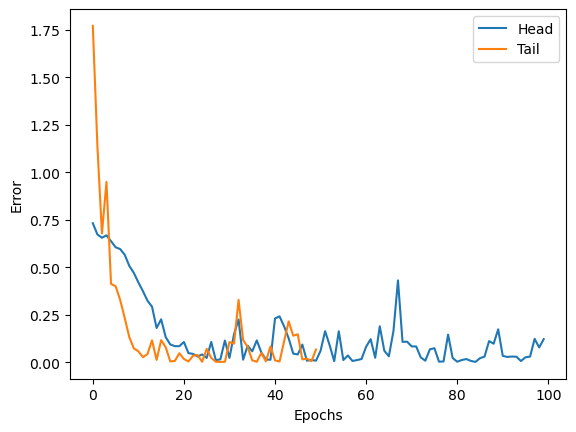

In [66]:
import matplotlib.pyplot as plt

plt.plot(range(len(h_test_loss_)), h_test_loss_, label="Head")
plt.plot(range(len(t_test_loss_)), t_test_loss_, label="Tail")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()  # ラベルがあるときは、きちんとplt.show()を呼び出すこと